# Comparing Machine Learning Techniques Using Pipelines - Lab

## Introduction

In this lab, you'lll use a Dataset created by Otto group, which was also used in a [Kaggle competition](https://www.kaggle.com/c/otto-group-product-classification-challenge/data).

The description of the data set is as follows:

The Otto Group is one of the world’s biggest e-commerce companies, with subsidiaries in more than 20 countries, including Crate & Barrel (USA), Otto.de (Germany) and 3 Suisses (France). They are selling millions of products worldwide every day, with several thousand products being added to our product line.

A consistent analysis of the performance of our products is crucial. However, due to their global infrastructure, many identical products get classified differently. Therefore, the quality of our product analysis depends heavily on the ability to accurately cluster similar products. The better the classification, the more insights Otto Group can generate about their product range.

In this lab, you'll use a data set containing:
- A column `id`, which is an anonymous id unique to a product
- 93 columns `feat_1`, `feat_2`, ..., `feat_93`, which are the various features of a product
- a column `target` - the class of a product


## Objectives

You will be able to:
- Compare different classification techniques
- Construct pipelines in scikit-learn
- Use pipelines in combination with GridSearchCV

## The Data Science Workflow

You will be following the data science workflow:

1. Initial data inspection, exploratory data analysis, and cleaning
2. Feature engineering and selection
3. Create a baseline model
4. Create a machine learning pipeline and compare results with the baseline model
5. Interpret the model and draw conclusions

##  Initial data inspection, exploratory data analysis, and cleaning

The data is stored in "otto_group.csv".

Things to do here:
- Check for NAs
- Check the distributions
- Check how many inputs there are
- ...

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

In [2]:
raw_df = pd.read_csv('otto_group.csv', index_col='id')
print(len(raw_df))
raw_df.head()

61878


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
4,1,0,0,1,6,1,5,0,0,1,...,0,1,2,0,0,0,0,0,0,Class_1
5,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [3]:
# No null values
raw_df.isna().sum().sum()

0

In [4]:
raw_df.target.value_counts()

Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: target, dtype: int64

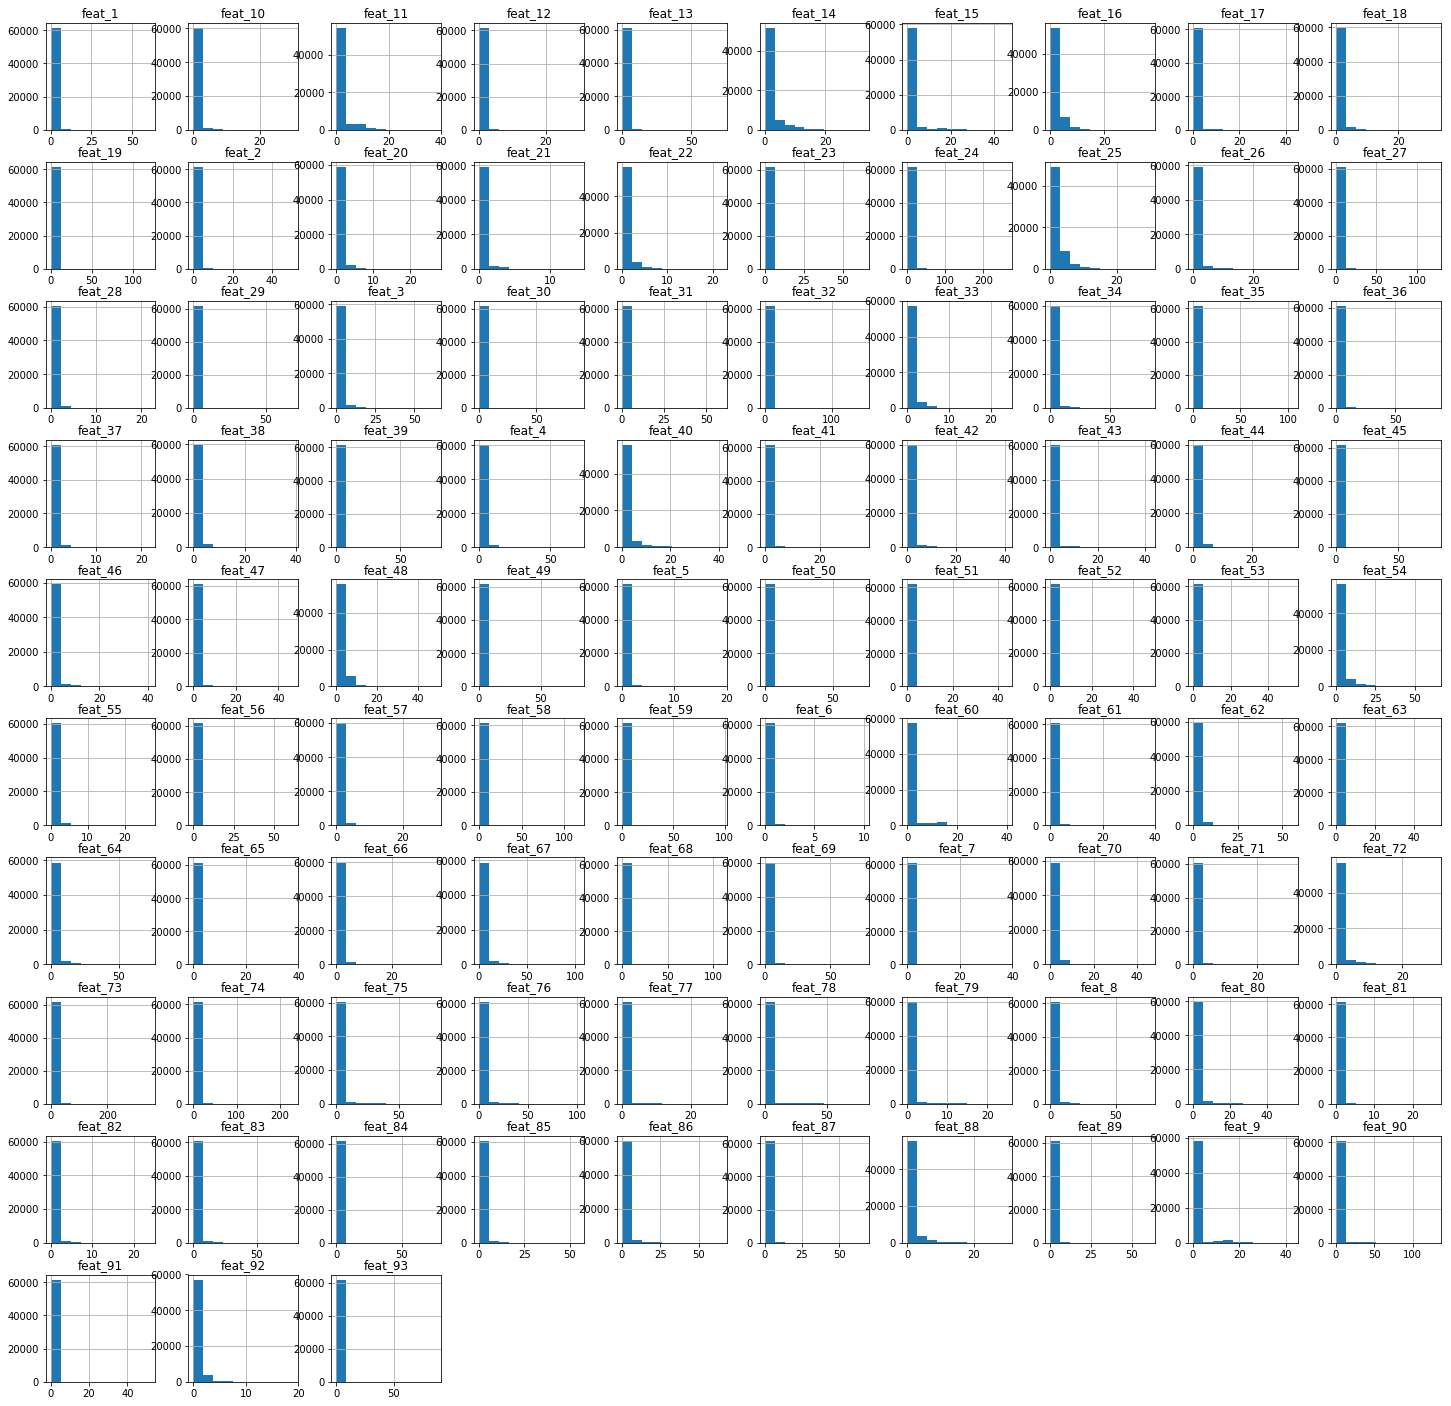

In [5]:
raw_df.hist(figsize=(25,25));

If you look at all the histograms, you can tell that a lot of the data are zero-inflated, so most of the variables contain mostly zeros and then some higher values here and there. No normality, but for most machine learning techniques this is not an issue. 

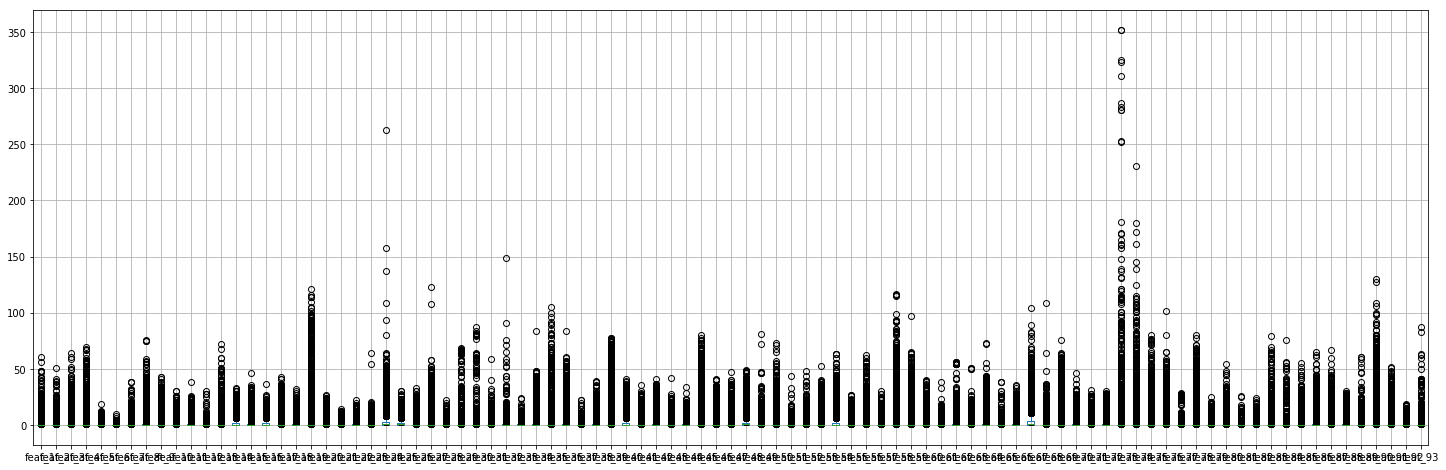

In [6]:
raw_df.boxplot(figsize=(25,8));

Because the data is zero-inflated the boxplots look as shown above. Because there are this many zeroes, most values above zero will seem to be outliers. The safe decision for this data is to not delete any outliers and see what happens. With many 0s, sparse data is available and high values may be super informative. More-over, without having any intuitive meaning for each of the features, we don't know if a value of ~260 is actually an outlier.

## Feature engineering and selection with PCA

Have a look at the correlation structure of your features using a heatmap.

In [7]:
X = raw_df.drop('target', axis=1)
y = raw_df.target

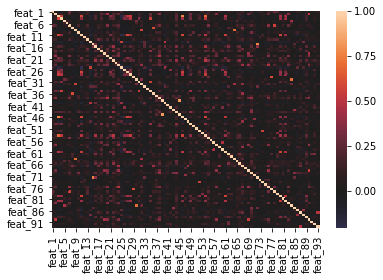

In [8]:
sns.heatmap(X.corr(), center=0);

Use PCA to downscale your features. Use PCA to select a number of features in a way that you still keep 80% of your explained variance.

In [9]:
pca = PCA(n_components=40)
pca.fit_transform(X)
explained_var = np.cumsum(pca.explained_variance_ratio_)

In [10]:
np.where(explained_var > 0.8)

(array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       dtype=int64),)

In [10]:
# The first iteration where the explained variance is over 80% is index 26, which is n_components = 27

In [11]:
pca = PCA(n_components=27)
principal_comps = pca.fit_transform(X)
np.sum(pca.explained_variance_ratio_)

0.8001738360125933

## Create a train test split with a test size of 40%

This is a relatively big training set. Feel free to make it smaller (down to ~20%), but for an initial run you can try smaller training sets so the computation time is more manageable.

For now, simply use the original data and not the principal components. We looked at the PC's first to get a sense of our correlation structure, and to see how we can downsize our data without losing too much information. In what's next, you'll make PCA part of the pipeline!!

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

## Create a baseline model

Create your baseline model *in a pipeline setting*. In the pipeline
- Your first step will be to scale your features down to the number of features that ensure you keep just 80% of your explained variance (which we saw before)
- Your second step will be the building a basic logistic regression model.

Make sure to fit the model using the training set, and test the result by obtaining the accuracy using the test set.

In [13]:
pipe = Pipeline([('pca', PCA(n_components=27)),
                ('clf', LogisticRegression())])
pipe.fit(X_train, y_train)
print(pipe.score(X_test, y_test))

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7162653522947641


## Create a pipeline consisting of a linear SVM, a simple Decision Tree and a simple Random Forest Classifier

Repeat the above, but now create three different pipelines:
- One for a standard linear SVM
- One for a default decision tree
- One for a RandomForestClassifier

In [14]:
# Adapted from https://www.kdnuggets.com/2017/12/managing-machine-learning-workflows-scikit-learn-pipelines-part-1.html

pipe_svm = Pipeline([('pca', PCA(n_components=27)),
                    ('clf', SVC())])
pipe_tree = Pipeline([('pca', PCA(n_components=27)),
                    ('clf', DecisionTreeClassifier())])
pipe_rf = Pipeline([('pca', PCA(n_components=27)),
                    ('clf', RandomForestClassifier())])
pipelines = [pipe_svm, pipe_tree, pipe_rf]
pipeline_names = ['Standard linear SVM', 'Decision tree', 'Random forest']

for pipe in pipelines:
    pipe.fit(X_train, y_train)

for index, pipe in enumerate(pipelines):
    print(pipeline_names[index] , "test accuracy:", pipe.score(X_test, y_test))

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Standard linear SVM test accuracy: 0.7440206851971558
Decision tree test accuracy: 0.6677440206851971
Random forest test accuracy: 0.7427278603749192


In [ ]:
# SVM has the highest score, but still only about .74

## Pipeline with grid search

Construct 3 pipelines with grid search
- one for support vector machines - make sure your grid isn't too big. You'll see it takes quite a while to fit SVMs with non-linear kernel functions!
- one for random forests - try to have around 40 different models
- one for the adaboost algorithm. 

### SVM pipeline with grid search

In [ ]:
pipe_svm = Pipeline([('pca', PCA(n_components=27)),
                    ('clf', SVC())])

grid_params_svm = [{'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
               {'clf__C': [1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf']}]

gs_svm = GridSearchCV(estimator=pipe_svm,
                  param_grid=grid_params_svm,
                  scoring='accuracy',
                  cv=3)

gs_svm.fit(X_train, y_train)

print("Best accuracy:", gs_svm.best_score_)
print("Best parameters:", gs_svm.best_params_)

Use your grid search object along with `.cv_results` to get the full result overview

In [ ]:
gs_svm.cv_results_

### Random Forest pipeline with grid search

In [16]:
pipe_rf = Pipeline([('pca', PCA(n_components=27)),
                    ('clf', RandomForestClassifier())])

grid_params_rf = [ 
  {'clf__n_estimators': [120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 6],  
   'clf__min_samples_leaf':[0.05, 0.2],  
   'clf__min_samples_split':[0.05, 0.2]
  }
]

gs_rf = GridSearchCV(estimator=pipe_rf,
                  param_grid=grid_params_rf,
                  scoring='accuracy',
                  cv=3)

gs_rf.fit(X_train, y_train)

print("Best accuracy:", gs_rf.best_score_)
print("Best parameters:", gs_rf.best_params_)

Best accuracy: 0.6178688789527554
Best parameters: {'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 120}


In [18]:
gs_rf.cv_results_

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\L

{'mean_fit_time': array([10.72265029,  9.26920374,  3.1941216 ,  3.2755537 , 11.59498366,
         9.15283434,  3.01559782,  3.04053243,  4.26159898,  3.77658312,
         2.07047645,  2.12331947,  4.72534243,  3.80349231,  2.07878979,
         2.07845648]),
 'std_fit_time': array([0.12492953, 0.07921453, 0.12759658, 0.06307016, 0.16405599,
        0.09931514, 0.05632585, 0.08618767, 0.01412807, 0.04491494,
        0.06293672, 0.1370665 , 0.10324861, 0.0963525 , 0.02522544,
        0.04620386]),
 'mean_score_time': array([0.15891854, 0.14328456, 0.14527798, 0.15491907, 0.16889707,
        0.14261778, 0.12833651, 0.12366931, 0.14529133, 0.14060569,
        0.12631218, 0.12734477, 0.15525166, 0.14097301, 0.13428799,
        0.12664469]),
 'std_score_time': array([0.0016775 , 0.00497488, 0.01387531, 0.01677408, 0.00895887,
        0.00776741, 0.00475389, 0.00081449, 0.00171227, 0.00778168,
        0.00542608, 0.00737965, 0.00978303, 0.00167199, 0.00049542,
        0.00353499]),
 'param_cl

## Adaboost

In [21]:
pipe_ada = Pipeline([('pca', PCA(n_components=27)),
                    ('clf', AdaBoostClassifier())])

grid_params_ada = [ 
  {'clf__n_estimators': [30, 70],
    'clf__learning_rate': [1.0, 0.1]
  }
]

gs_ada = GridSearchCV(estimator=pipe_ada,
                  param_grid=grid_params_ada,
                  scoring='accuracy',
                  cv=3, verbose=2)

gs_ada.fit(X_train, y_train)

print("Best accuracy:", gs_ada.best_score_)
print("Best parameters:", gs_ada.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   5.1s
[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.4s remaining:    0.0s


[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   5.2s
[CV] clf__learning_rate=1.0, clf__n_estimators=30 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=30, total=   5.5s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=70, total=  13.3s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=70, total=  12.1s
[CV] clf__learning_rate=1.0, clf__n_estimators=70 ....................
[CV] ..... clf__learning_rate=1.0, clf__n_estimators=70, total=  11.4s
[CV] clf__learning_rate=0.1, clf__n_estimators=30 ....................
[CV] ..... clf__learning_rate=0.1, clf__n_estimators=30, total=   4.8s
[CV] clf__learning_rate=0.1, clf__n_estimators=30 ....................
[CV] ..... clf__learning_rate=0.1, clf__n_estimators=30, total=   4.7s
[CV] clf__learning_rate=0.1, clf__n_estimators=30 ....................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  1.8min finished


Best accuracy: 0.633841512686527
Best parameters: {'clf__learning_rate': 0.1, 'clf__n_estimators': 70}


In [23]:
gs_ada.cv_results_

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\L

{'mean_fit_time': array([ 5.24429202, 12.1910545 ,  4.64623753, 11.47231086]),
 'std_fit_time': array([0.16849668, 0.77057518, 0.1352616 , 1.08749171]),
 'mean_score_time': array([0.11436574, 0.20279145, 0.09541146, 0.2021265 ]),
 'std_score_time': array([0.00824103, 0.02076666, 0.00734379, 0.0419138 ]),
 'param_clf__learning_rate': masked_array(data=[1.0, 1.0, 0.1, 0.1],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__n_estimators': masked_array(data=[30, 70, 30, 70],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf__learning_rate': 1.0, 'clf__n_estimators': 30},
  {'clf__learning_rate': 1.0, 'clf__n_estimators': 70},
  {'clf__learning_rate': 0.1, 'clf__n_estimators': 30},
  {'clf__learning_rate': 0.1, 'clf__n_estimators': 70}],
 'split0_test_score': array([0.6341089 , 0.62126353, 0.56414607, 0.63774439]),
 'split1_test_score': array([0.63830303, 0.61

## Note

Note that this solution is only one of many options. The results in the Random Forest and Adaboost models show that there is a lot of improvement possible tuning the hyperparameters further, so make sure to explore this yourself!

## Summary 

Great! You now got a lot of practice in. What algorithm would you choose and why?